# Class for HKStock from MySQL

In [1]:
%matplotlib notebook

from HKStock import HKStock


# Class for Strategy
## SMA Cross Over

In [2]:
from pyalgotrade import strategy
from pyalgotrade.technical import ma
from pyalgotrade.technical import rsi
from pyalgotrade.technical import cross

#############################################
class MyStrategy(strategy.BacktestingStrategy):
    def __init__(self, feed, instrument, entrySMA, exitSMA, rsiPeriod, overBoughtThreshold, overSoldThreshold):
        super(MyStrategy, self).__init__(feed)
        self.__instrument = instrument
        # We'll use adjusted close values, if available, instead of regular close values.
        if feed.barsHaveAdjClose():
            self.setUseAdjustedValues(True)
        self.__priceDS = feed[instrument].getPriceDataSeries()
        self.__entrySMA = ma.SMA(self.__priceDS, entrySMA)
        self.__exitSMA = ma.SMA(self.__priceDS, exitSMA)
        self.__rsi = rsi.RSI(self.__priceDS, rsiPeriod)
        self.__overBoughtThreshold = overBoughtThreshold
        self.__overSoldThreshold = overSoldThreshold
        self.__longPos = None
        self.__shortPos = None

    def getEntrySMA(self):
        return self.__entrySMA

    def getExitSMA(self):
        return self.__exitSMA

    def getRSI(self):
        return self.__rsi

    def onEnterCanceled(self, position):
        if self.__longPos == position:
            self.__longPos = None
        elif self.__shortPos == position:
            self.__shortPos = None
        else:
            assert(False)

    def onExitOk(self, position):
        if self.__longPos == position:
            self.__longPos = None
        elif self.__shortPos == position:
            self.__shortPos = None
        else:
            assert(False)

    def onExitCanceled(self, position):
        # If the exit was canceled, re-submit it.
        position.exitMarket()

    def onBars(self, bars):
        # Wait for enough bars to be available to calculate SMA and RSI.
        if self.__exitSMA[-1] is None or self.__entrySMA[-1] is None or self.__rsi[-1] is None:
            return

        bar = bars[self.__instrument]
        if self.__longPos is not None:
            if self.exitLongSignal():
                self.__longPos.exitMarket()
        elif self.__shortPos is not None:
            if self.exitShortSignal():
                self.__shortPos.exitMarket()
        else:
            if self.enterLongSignal(bar):
                shares = int(self.getBroker().getCash() * 0.9 / bars[self.__instrument].getPrice())
                self.__longPos = self.enterLong(self.__instrument, shares, True)
            elif self.enterShortSignal(bar):
                shares = int(self.getBroker().getCash() * 0.9 / bars[self.__instrument].getPrice())
                self.__shortPos = self.enterShort(self.__instrument, shares, True)

    def enterLongSignal(self, bar):
        return bar.getPrice() > self.__entrySMA[-1] and self.__rsi[-1] <= self.__overSoldThreshold

    def exitLongSignal(self):
        return cross.cross_above(self.__priceDS, self.__exitSMA) and not self.__longPos.exitActive()

    def enterShortSignal(self, bar):
        return bar.getPrice() < self.__entrySMA[-1] and self.__rsi[-1] >= self.__overBoughtThreshold

    def exitShortSignal(self):
        return cross.cross_below(self.__priceDS, self.__exitSMA) and not self.__shortPos.exitActive()
    

Sharpe ratio: -0.50


<IPython.core.display.Javascript object>


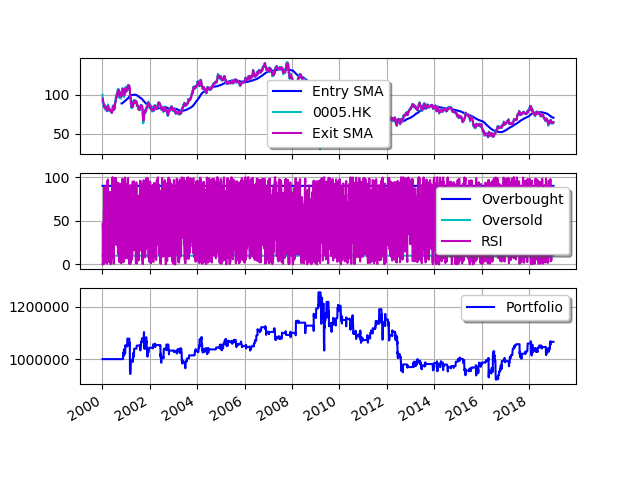

In [3]:

st = HKStock('0005.HK')

#############################################
from pyalgotrade.barfeed.csvfeed import GenericBarFeed
from pyalgotrade.bar import Frequency
import datetime as dt
#############################################
from pyalgotrade import plotter
from pyalgotrade.stratanalyzer import sharpe

#############################################
def main(plot):
    instrument = st.symbol
    entrySMA = 200
    exitSMA = 5
    rsiPeriod = 2
    overBoughtThreshold = 90
    overSoldThreshold = 10
    startDate=dt.datetime.strptime('2000-01-01', '%Y-%m-%d').date()
    endDate=dt.datetime.now().date()

    # Load the bars. These files were manually downloaded from Yahoo Finance.
    
    feed = GenericBarFeed(Frequency.DAY,maxLen=20000)
    feed.setDateTimeFormat('%Y-%m-%d')
    feed.addBarsFromCSV(st.symbol, st.saveCSV(startDate,endDate))

    strat = MyStrategy(feed, instrument, entrySMA, exitSMA, rsiPeriod, overBoughtThreshold, overSoldThreshold)
    sharpeRatioAnalyzer = sharpe.SharpeRatio()
    strat.attachAnalyzer(sharpeRatioAnalyzer)

    if plot:
        plt = plotter.StrategyPlotter(strat, True, False, True)
        plt.getInstrumentSubplot(instrument).addDataSeries("Entry SMA", strat.getEntrySMA())
        plt.getInstrumentSubplot(instrument).addDataSeries("Exit SMA", strat.getExitSMA())
        plt.getOrCreateSubplot("rsi").addDataSeries("RSI", strat.getRSI())
        plt.getOrCreateSubplot("rsi").addLine("Overbought", overBoughtThreshold)
        plt.getOrCreateSubplot("rsi").addLine("Oversold", overSoldThreshold)

    strat.run()
    print("Sharpe ratio: %.2f" % sharpeRatioAnalyzer.getSharpeRatio(0.05))

    if plot:
        plt.plot()

#############################################
if __name__ == "__main__":
    main(True)